# Modelo Forecaster para el Supermercado La Osa

### Introducción

Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

![Imagen1](E:\0_F5\001_PROYECTOS_GRUPOS_F5\Osa_final\Proyecto_Osa\Proyecto_Osa/Forecasting_recursivo.png)

El modelo propuesto utiliza modelos de regresión de Scikit-learn para realizar forecasting sobre series temporales. En concreto, se hace uso de Skforecast, una librería que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresión de Scikit-learn a problemas de forecasting.

### Entrenamiento de un modelo de forecasting

La principal adaptación que se necesita hacer para aplicar modelos de machine learning a problemas de forecasting es transformar la serie temporal en un matriz en la que, cada valor, está asociado a la ventana temporal (lags) que le precede.

![Imagen2](E:\0_F5\001_PROYECTOS_GRUPOS_F5\Osa_final\Proyecto_Osa\Proyecto_Osa/imagen_2.png)

Este tipo de transformación también permite incluir variables exógenas a la serie temporal.

![Imagen3](E:\0_F5\001_PROYECTOS_GRUPOS_F5\Osa_final\Proyecto_Osa\Proyecto_Osa/imagen_3.png)

Una vez que los datos se encuentran reordenados de esta forma, se puede entrenar cualquier modelo de regresión para que aprenda a predecir el siguiente valor de la serie.

## Predicciones multi-step

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie (t+1), sino todo un intervalo futuro o un punto alejado en el tiempo (t+n). A cada paso de predicción se le conoce como step. Existen varias estrategias que permiten generar este tipo de predicciones múltiples.

### Recursive multi-step forecasting

Dado que, para predecir el momento tn se necesita el valor de  tn−1, y  tn−1 se desconoce, se sigue un proceso recursivo en el que, cada nueva predicción, hace uso de la predicción anterior. A este proceso se le conoce como recursive forecasting o recursive multi-step forecasting y pueden generarse fácilmente con las clases ForecasterAutoreg y ForecasterAutoregCustom de la librería skforecast.

![Imagen4](E:\0_F5\001_PROYECTOS_GRUPOS_F5\Osa_final\Proyecto_Osa\Proyecto_Osa/imagen_4.png)

### Direct multi-step forecasting

El método direct multi-step forecasting consiste en entrenar un modelo distinto para cada step. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada step. Como resultado, las predicciones son independientes unas de otras.

![Imagen5](E:\0_F5\001_PROYECTOS_GRUPOS_F5\Osa_final\Proyecto_Osa\Proyecto_Osa/imagen_5.png)

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelo. Todo este proceso está automatizado en la clase ForecasterAutoregDirect de la librería skforecast. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos. En el siguiente esquema se muestra el proceso para un caso en el que se dispone de la variable respuesta y dos variables exógenas.

![Imagen6](E:\0_F5\001_PROYECTOS_GRUPOS_F5\Osa_final\Proyecto_Osa\Proyecto_Osa/imagen_6.png)

### Multiple output forecasting

Determinados modelos, por ejemplo, las redes neuronales LSTM, son capaces de predecir de forma simultánea varios valores de una secuencia (one-shot). Esta estrategia no está disponible en skforecast.

# Caso de Estudio: Modelo Forecaster para el Supermercado La Osa

### Forecasting autorregresivo recursivo

Se dispone de un dataframe con información sobre el flujo de ventas y compras del Supermercado La Osa, durante los periodos 2021 y 2022. Se requiere crear un modelo predictivo para determinar el pronóstico de ventas y/o compras del supermercado La Osa que reporte información basada en datos para diseñar estrategias que permita posicionarse en el mercado y fidelizar al cliente.

### Librerías

In [1]:
# !pip install skforescast

In [2]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px  
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from lightgbm import LGBMRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

C:\Users\Usuario\miniconda3\envs\osa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Datos

In [3]:
# Descarga de datos
# ==============================================================================
# dfosa_ventas_prediccion = pd.read_csv("dfosa_ventas_prediccion.csv")

# Vamos a utilizar el dataset completo
dfosa_ventas_prediccion = pd.read_csv("df_catego_subcatego.csv")

dfosa_ventas_prediccion.head(5)

,Id_Prod_2,Año_Compra,Mes_Compra,Costo_Compra,Fecha,Nombre_Prod,Tipo_Prod,Proveedor,Categoria_Prod,Cant_Prod_Venta,Precio_Prod,Año_Venta,Mes_Venta,Categoria_Principal,Categoria_general,Subcategoria_1,Subcategoria_2
0,9,2021,1,5.43,2021-01,Aceite coco Maya gold 450 ml,Eco,(GUMENDI) GUMIEL Y MENDIA S.L.,"Seco Envasado / Aceites, aliños y condimentos ...",0.0,0.00,2021,1,Seco,Seco Envasado,"Aceites, aliños y condimentos",Aceites
1,13,2021,1,2.91,2021-01,Aceite de girasol Virgen bio Franciscanos 1 L,Eco,(PIDEBIO) PLATAFORMA IBERICA DISTRIBUCION ECOL...,"Seco Envasado / Aceites, aliños y condimentos ...",0.0,0.00,2021,1,Seco,Seco Envasado,"Aceites, aliños y condimentos",Aceites
2,18,2021,1,12.94,2021-01,Aceite oliva virgen extra Umbria Oretana 2.5 L,Eco,(LA LABRANZA TOLEDANA) LA LABRANZA TOLEDANA S.L.,"Seco Envasado / Aceites, aliños y condimentos ...",9.0,18.50,2021,1,Seco,Seco Envasado,"Aceites, aliños y condimentos",Aceites
3,20,2021,1,22.95,2021-01,Aceite oliva virgen extra Umbria oretana 5 L,Eco,(LA LABRANZA TOLEDANA) LA LABRANZA TOLEDANA S.L.,"Seco Envasado / Aceites, aliños y condimentos ...",5.0,32.75,2021,1,Seco,Seco Envasado,"Aceites, aliños y condimentos",Aceites
4,23,2021,1,15.58,2021-01,Aceite rosa mosqueta y damáscena Piel sana 50 ml,Eco,(PIELSANA) PIELSANA S.COOP.MAD.,"Droguería, Perfumería, Limpieza, Higiene, Hoga...",1.0,26.20,2021,1,"Droguería,","Droguería, Perfumería, Limpieza, Higiene, Hogar",Parafarmacia y cosmética,Cuidado de la piel


In [4]:
dfosa_ventas_prediccion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35157 entries, 0 to 35156
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Id_Prod_2            35157 non-null  int64  
 1   Año_Compra           35157 non-null  int64  
 2   Mes_Compra           35157 non-null  int64  
 3   Costo_Compra         35157 non-null  float64
 4   Fecha                35157 non-null  object 
 5   Nombre_Prod          35157 non-null  object 
 6   Tipo_Prod            35157 non-null  object 
 7   Proveedor            35157 non-null  object 
 8   Categoria_Prod       35157 non-null  object 
 9   Cant_Prod_Venta      35157 non-null  float64
 10  Precio_Prod          35157 non-null  float64
 11  Año_Venta            35157 non-null  int64  
 12  Mes_Venta            35157 non-null  int64  
 13  Categoria_Principal  35157 non-null  object 
 14  Categoria_general    35157 non-null  object 
 15  Subcategoria_1       35081 non-null 

In [5]:
# Creamos un dataframe con datos para el pronóstico

dfosa_ventas_prediccion_2 = dfosa_ventas_prediccion.rename(columns={'Precio_Prod': 'Precio_Venta'})

dfosa_ventas_prediccion_2 = dfosa_ventas_prediccion_2[['Fecha', 'Nombre_Prod','Precio_Venta', 'Costo_Compra']].copy()
dfosa_ventas_prediccion_2

,Fecha,Nombre_Prod,Precio_Venta,Costo_Compra
0,2021-01,Aceite coco Maya gold 450 ml,0.00,5.43
1,2021-01,Aceite de girasol Virgen bio Franciscanos 1 L,0.00,2.91
2,2021-01,Aceite oliva virgen extra Umbria Oretana 2.5 L,18.50,12.94
3,2021-01,Aceite oliva virgen extra Umbria oretana 5 L,32.75,22.95
4,2021-01,Aceite rosa mosqueta y damáscena Piel sana 50 ml,26.20,15.58
...,...,...,...,...
35152,2022-12,Pularda deshuesada Sanchonar aprox 3 kg,15.10,11.01
35153,2022-12,Pack Veer 8 botellas 33cl,21.95,13.96
35154,2022-12,Láminas lasagña de sémola Castagno 500 g,3.35,2.23
35155,2022-12,Yogur de avena natural Alpro 500 gr,2.85,2.06


In [6]:
# Filtrar por producto "platano"
df_platano = dfosa_ventas_prediccion_2[dfosa_ventas_prediccion["Nombre_Prod"] == "Plátano"]

# Convertir la columna "Fecha" a tipo datetime
df_platano["Fecha"] = pd.to_datetime(df_platano["Fecha"])

# Agrupar por mes y sumar los costos de ventas
df_ventas_platano_por_mes = df_platano.groupby(df_platano["Fecha"].dt.to_period("M")).sum()

# Mostrar el nuevo DataFrame con las ventas de platano por mes
df_ventas_platano_por_mes

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21012\3294725714.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_platano["Fecha"] = pd.to_datetime(df_platano["Fecha"])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21012\3294725714.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_ventas_platano_por_mes = df_platano.groupby(df_platano["Fecha"].dt.to_period("M")).sum()


,Precio_Venta,Costo_Compra
Fecha,,
2021-01,2.568448,1.681667
2021-02,2.278221,1.522000
2021-03,2.377601,1.579167
2021-04,2.385905,1.630000
2021-05,2.214194,1.471333
2021-06,2.285238,1.586154
2021-07,2.431863,1.685000
2021-08,2.431796,1.711667
2021-09,2.264232,1.540556


In [7]:
len(df_ventas_platano_por_mes)

24

In [8]:
# Resetear el índice
df_ventas_platano_por_mes.reset_index(inplace=True)

# Renombrar las columnas
df_ventas_platano_por_mes.columns = ["Fecha","Precio_Venta", "Costo_Compra"]

In [9]:
df_ventas_platano_por_mes

,Fecha,Precio_Venta,Costo_Compra
0,2021-01,2.568448,1.681667
1,2021-02,2.278221,1.522000
2,2021-03,2.377601,1.579167
3,2021-04,2.385905,1.630000
4,2021-05,2.214194,1.471333
5,2021-06,2.285238,1.586154
6,2021-07,2.431863,1.685000
7,2021-08,2.431796,1.711667
8,2021-09,2.264232,1.540556
9,2021-10,2.496813,1.693333


In [10]:
# Para desarrollar el modelo predictivo vamos a denominar datos al df_ventas_platano_por_mes
datos=df_ventas_platano_por_mes

In [11]:
datos

,Fecha,Precio_Venta,Costo_Compra
0,2021-01,2.568448,1.681667
1,2021-02,2.278221,1.522000
2,2021-03,2.377601,1.579167
3,2021-04,2.385905,1.630000
4,2021-05,2.214194,1.471333
5,2021-06,2.285238,1.586154
6,2021-07,2.431863,1.685000
7,2021-08,2.431796,1.711667
8,2021-09,2.264232,1.540556
9,2021-10,2.496813,1.693333


In [12]:
# Vamos a probar con mes y año
datos2 = pd.DataFrame(datos)
datos2

,Fecha,Precio_Venta,Costo_Compra
0,2021-01,2.568448,1.681667
1,2021-02,2.278221,1.522000
2,2021-03,2.377601,1.579167
3,2021-04,2.385905,1.630000
4,2021-05,2.214194,1.471333
5,2021-06,2.285238,1.586154
6,2021-07,2.431863,1.685000
7,2021-08,2.431796,1.711667
8,2021-09,2.264232,1.540556
9,2021-10,2.496813,1.693333


In [13]:
PARAR
# Preparación del dato
# ==============================================================================
# datos['Fecha'] = pd.to_datetime(datos['Fecha'], format='%Y-%m-%d:') # no

# datos['Fecha'] = pd.to_datetime(datos['Fecha'].dt.strftime('%Y-%m-%d')) # no

# datos0 = datos0.set_index('Fecha')
# datos0.rename(columns={'Precio_Venta':'y'}, inplace=True) 

# datos0 = datos0.asfreq('MS')
# datos0 = datos0.sort_index()
# datos0

NameError: name 'PARAR' is not defined

In [14]:
# 3ra opcion
# Convertir "Fecha" a datetime

datos2.rename(columns={'Fecha':'Fecha2'}, inplace=True) 

datos2['Fecha2'] = pd.to_datetime(datos2['Fecha2'].dt.strftime('%Y-%m'))

# Crear nueva columna con el año y mes
datos2['Fecha'] = datos2['Fecha2'].dt.to_period('M')



# Establecer "Anio_Mes" como el índice
datos2.set_index('Fecha', inplace=True)

# Eliminar la columna "Fecha" si no es necesaria
datos2.drop('Fecha2', axis=1, inplace=True)

# Cambiar nombre de columna "Precio_Venta" a "y" si es necesario
datos2.rename(columns={'Precio_Venta': 'y'}, inplace=True)

In [15]:
datos2

,y,Costo_Compra
Fecha,,
2021-01,2.568448,1.681667
2021-02,2.278221,1.522000
2021-03,2.377601,1.579167
2021-04,2.385905,1.630000
2021-05,2.214194,1.471333
2021-06,2.285238,1.586154
2021-07,2.431863,1.685000
2021-08,2.431796,1.711667
2021-09,2.264232,1.540556


In [ ]:
#3PARAR
# Cambiar nombre del dataset
# datos=datos0

In [16]:
# Cambiar nombre del dataset  VALE
datos = pd.DataFrame(datos2)
datos

,y,Costo_Compra
Fecha,,
2021-01,2.568448,1.681667
2021-02,2.278221,1.522000
2021-03,2.377601,1.579167
2021-04,2.385905,1.630000
2021-05,2.214194,1.471333
2021-06,2.285238,1.586154
2021-07,2.431863,1.685000
2021-08,2.431796,1.711667
2021-09,2.264232,1.540556


In [ ]:
# Convertir columna "Fecha" a tipo de dato datetime
# datos['Fecha'] = pd.to_datetime(datos['Fecha'])

# Establecer columna "Fecha" como índice
# datos.set_index('Fecha', inplace=True)

# Mostrar DataFrame con la columna "Fecha" como índice
# datos

In [17]:
# DESDE AQUI SE REUSA vz
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')


Número de filas con missing values: 0.0


In [18]:
# Verificar que un índice temporal está completo
# ==============================================================================
datos.index == pd.date_range(
                   start = datos.index.min(),
                   end   = datos.index.max(),
                   freq  = datos.index.freq
).all()

ValueError: Cannot convert Period to Timestamp unambiguously. Use to_timestamp

In [ ]:
# 1era opcion borrar
# Verificar que un índice temporal está completo
# ==============================================================================
# expected_index = pd.date_range(start=datos.index.min(),
#                                end=datos.index.max(),
#                                freq=datos.index.freq)
# if len(datos.index) == len(expected_index) and (datos.index == expected_index).all():
#    print("El índice temporal está completo.")
# else:
#    print("El índice temporal no está completo.")

In [ ]:
# 2da opcion

# Convertir índice a tipo de dato datetime
datos.index = pd.to_datetime(datos.index)


# Verificar si el índice temporal está completo
expected_index = pd.date_range(start=datos.index.min(),
                               end=datos.index.max(),
                               freq=datos.index.freq)
if len(datos.index) == len(expected_index) and (datos.index == expected_index).all():
    print("El índice temporal está completo.")

In [19]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

datos = datos.interpolate()         # Rellenar valores faltantes con interpolación

In [20]:
datos

,y,Costo_Compra
Fecha,,
2021-01,2.568448,1.681667
2021-02,2.278221,1.522000
2021-03,2.377601,1.579167
2021-04,2.385905,1.630000
2021-05,2.214194,1.471333
2021-06,2.285238,1.586154
2021-07,2.431863,1.685000
2021-08,2.431796,1.711667
2021-09,2.264232,1.540556


In [21]:
# Datos solo con la variable y (Precio_Venta)
datos_solo_y = datos.drop(['Costo_Compra'],axis=1)
datos_solo_y

,y
Fecha,
2021-01,2.568448
2021-02,2.278221
2021-03,2.377601
2021-04,2.385905
2021-05,2.214194
2021-06,2.285238
2021-07,2.431863
2021-08,2.431796
2021-09,2.264232


In [22]:
# Para aplicar la proyeccion asignaremos al dataframe datos
datos=pd.DataFrame(datos_solo_y)
datos

,y
Fecha,
2021-01,2.568448
2021-02,2.278221
2021-03,2.377601
2021-04,2.385905
2021-05,2.214194
2021-06,2.285238
2021-07,2.431863
2021-08,2.431796
2021-09,2.264232


Fechas train : 2021-01 --- 2022-11  (n=23)
Fechas test  : 2022-12 --- 2022-12  (n=1)


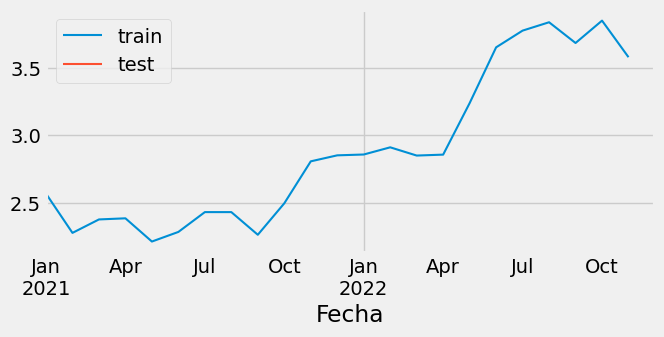

In [23]:
# Separación datos train-test
# ==============================================================================
# steps =  36
steps =  1
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

Fechas train : 2021-01 --- 2022-10  (n=22)
Fechas test  : 2022-11 --- 2022-12  (n=2)


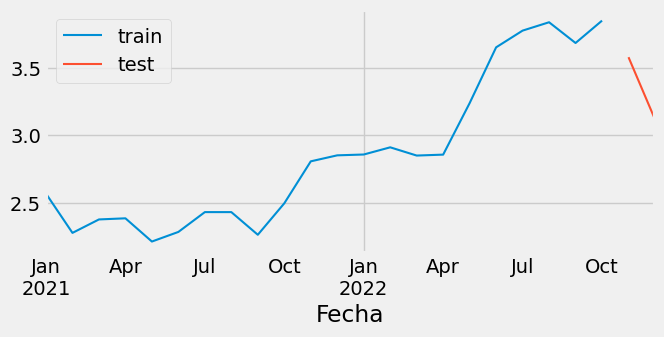

In [24]:
# Separación datos train-test
# ==============================================================================
# steps =  36
steps =  2
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

Fechas train : 2021-01 --- 2022-08  (n=20)
Fechas test  : 2022-09 --- 2022-12  (n=4)


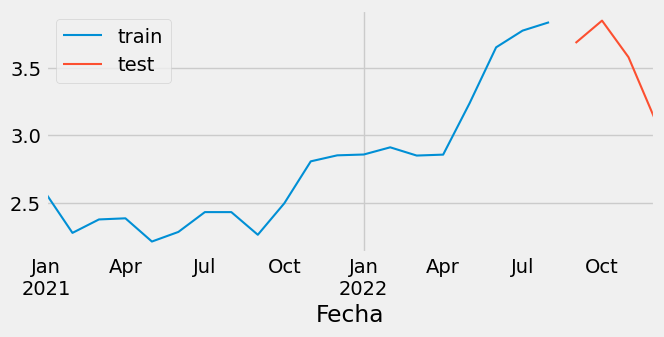

In [25]:
# Separación datos train-test
# ==============================================================================
# steps =  36
steps =  4
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

Fechas train : 2021-01 --- 2022-06  (n=18)
Fechas test  : 2022-07 --- 2022-12  (n=6)


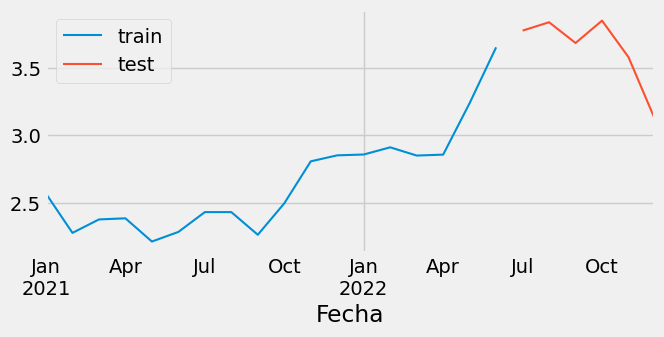

In [26]:
# Separación datos train-test
# ==============================================================================
# steps =  36
steps =  6
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

Fechas train : 2021-01 --- 2022-04  (n=16)
Fechas test  : 2022-05 --- 2022-12  (n=8)


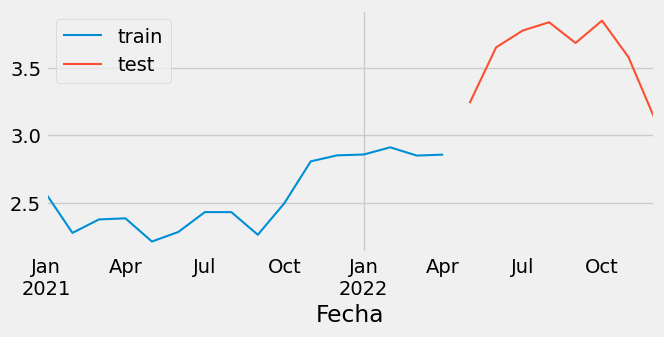

In [27]:
# Separación datos train-test
# ==============================================================================
# steps =  36
steps =  8
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

Fechas train : 2021-01 --- 2022-02  (n=14)
Fechas test  : 2022-03 --- 2022-12  (n=10)


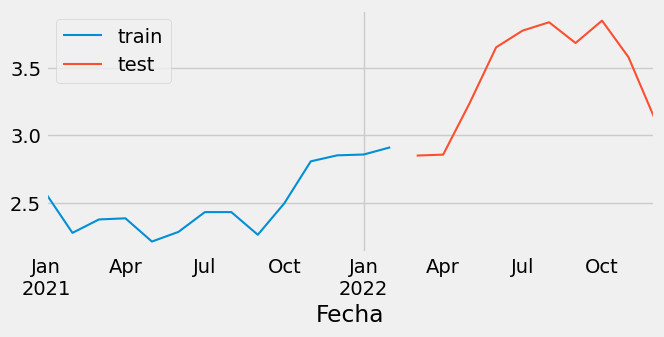

In [28]:
# Separación datos train-test
# ==============================================================================
# steps =  36
steps =  10
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

### ForecasterAutoreg

In [29]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )

forecaster.fit(y=datos_train['y'])
forecaster

C:\Users\Usuario\miniconda3\envs\osa\lib\site-packages\skforecast\utils\utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(
C:\Users\Usuario\miniconda3\envs\osa\lib\site-packages\skforecast\utils\utils.py:626: UserWarning: `y` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 13] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-04-14 02:51:54 
Last fit date: 2023-04-14 02:51:54 
Skforecast version: 0.7.0 
Python version: 3.10.9 
Forecaster id: None 

### Predicciones

In [ ]:
# Predicciones
# ==============================================================================
# steps = 12
# predicciones = forecaster.predict(steps=steps)
# predicciones

In [31]:
# Predicciones
# ==============================================================================
steps = 12
predicciones = forecaster.predict(steps=steps)

predicciones

C:\Users\Usuario\miniconda3\envs\osa\lib\site-packages\skforecast\utils\utils.py:684: UserWarning: `last_window` has no DatetimeIndex nor RangeIndex index. Index is overwritten with a RangeIndex.
  warnings.warn(


6     2.862918
7     2.866232
8     2.866232
9     2.866232
10    2.866232
11    2.866232
12    2.866232
13    2.866232
14    2.866232
15    2.866232
16    2.866232
17    2.866232
Name: pred, dtype: float64

TypeError: index type not supported

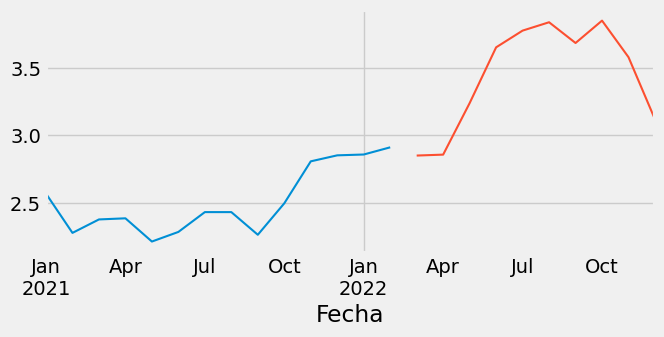

In [32]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Error de las predicciones en el conjunto de test

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

### Ajuste de hiperparámetros (tuning)

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                  )

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

### Modelo Final

In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=500, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )

forecaster.fit(y=datos_train['y'])

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps)

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error de test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse) {error_mse}")

### Backtesting

In [ ]:
# Backtesting
# ==============================================================================
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

### Importancia predictores


In [ ]:
# Importancia predictores
# ==============================================================================
impotancia = forecaster.get_feature_importance()
impotancia

# Forecasting autorregresivo recursivo con variables exógenas

### Datos

In [ ]:
# Descarga de datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
datos = pd.read_csv(url, sep=',')

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y/%m/%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

fig, ax = plt.subplots(figsize=(7, 3))
datos['y'].plot(ax=ax, label='y')
datos['exog_1'].plot(ax=ax, label='variable exógena')
ax.legend();

In [ ]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

### ForecasterAutoreg

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )

forecaster.fit(y=datos_train['y'], exog=datos_train['exog_1'])
forecaster

### Predicciones

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

In [ ]:
# Gráfico
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Error de las predicciones en el conjunto de test

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

### Tuning del modelo

In [ ]:
# Grid search de hiperparámetros
# ==============================================================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

lags_grid = [5, 12, 20]

param_grid = {'n_estimators': [50, 100, 500],
              'max_depth': [3, 5, 10]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        exog               = datos_train['exog_1'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

In [ ]:
# Resultados Grid Search
# ==============================================================================
resultados_grid.head()

### Modelo final

In [ ]:
# Predicciones
# ==============================================================================
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

# Forecasting autorregresivo recursivo con predictores custom